In [1]:
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 12, 27)
btc_data = yf.download('BTC-USD', start=start, end=end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [2]:
# 필요한 컬럼 선택
btc_data = btc_data[['Close']]
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btc_data)

In [3]:
# 학습 데이터 생성 함수
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

In [4]:
# 데이터 차원 변환 [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [5]:
# 모델 생성 (GRU 사용)
model = Sequential([
    GRU(200, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    GRU(200, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# 모델 컴파일
model.compile(optimizer=Adam(), loss='mean_squared_error')

In [7]:
# 모델 학습
model.fit(X, y, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0160
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8.2578e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.3063e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4872e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.0028e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0712e-04
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3901e-04
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.2030e-04
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9323e-04
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.9250e-04
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018
Epoch 13/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3111e-04
Epoch 14/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.1810e-04
Epoch 15/50
56/56 ━━━━━━━━━━━━━━━━━━

In [8]:
# 예측 데이터 생성
train_size = int(len(scaled_data) * 0.8)
test_data = scaled_data[train_size - time_step:]

X_test, y_test = create_dataset(test_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# 예측 결과 저장
results_df = pd.DataFrame({'datetime': btc_data.index[-len(predictions):], 'prediction': predictions.flatten()})
results_df.to_csv("gru_predictions.csv", index=False)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [12]:
# 실제 Close 가격과 예측값을 함께 저장하기
btc_data = btc_data[['Close']]
df = pd.read_csv("gru_predictions.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# 예측값과 실제 Close 가격을 합친 데이터프레임 만들기
btc_data = btc_data.loc[df.index]  # 예측값과 일치하는 날짜의 실제 Close 가격
df['actual_close'] = btc_data['Close']

# DataFrame을 다시 저장.
df.to_csv("gru_predictions_with_actual.csv", index=True)

<Figure size 1400x700 with 0 Axes>

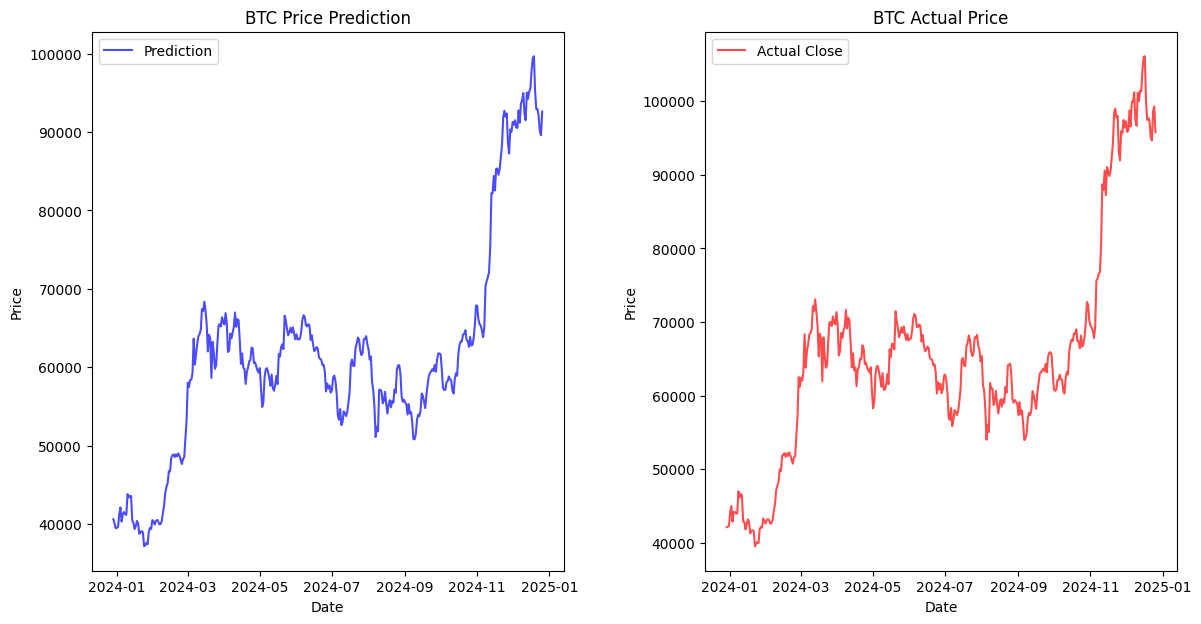

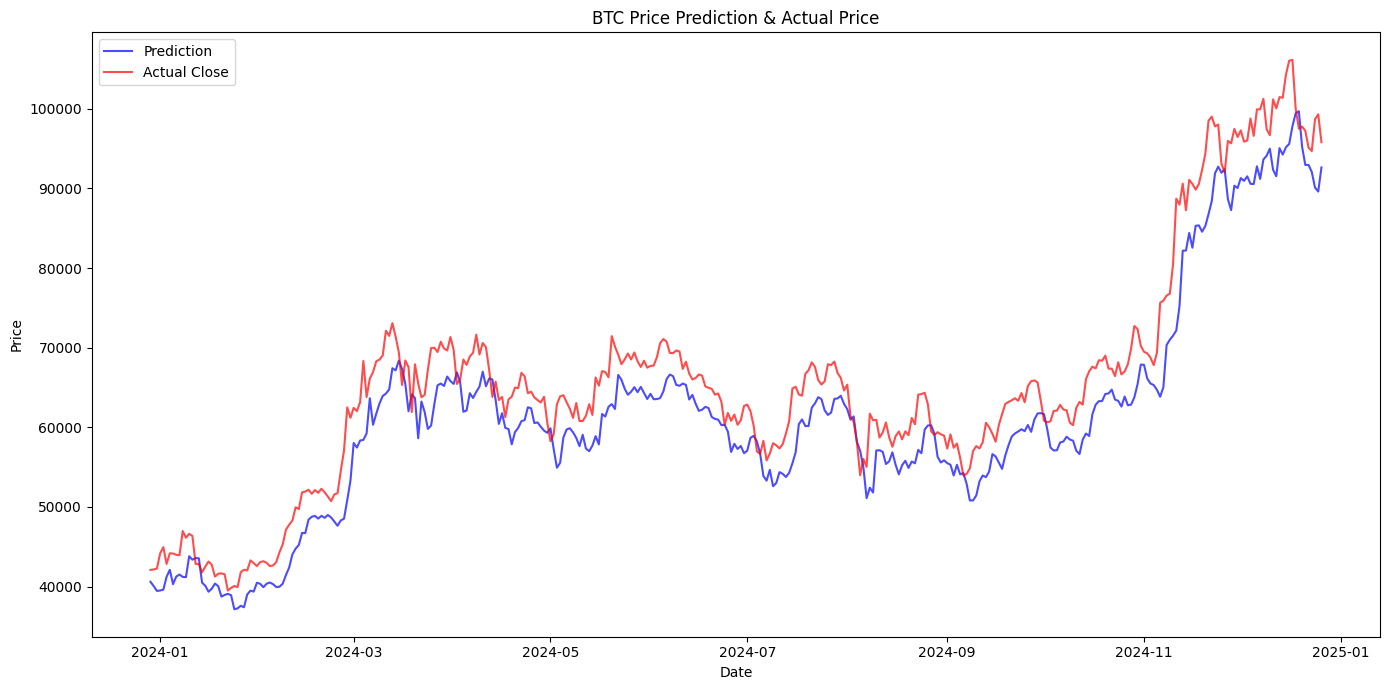

In [13]:
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv("gru_predictions_with_actual.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# 그래프 그리기
plt.figure(figsize=(14, 7))


# 첫 번째 그래프: 예측값 (Prediction)과 실제값 (Actual) 나누어 출력
plt.figure(figsize=(14, 7))

# 예측값만 출력 (왼쪽)
plt.subplot(1, 2, 1)
plt.plot(df.index, df['prediction'], label='Prediction', color='blue', alpha=0.7)
plt.title('BTC Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# 실제값만 출력 (오른쪽)
plt.subplot(1, 2, 2)
plt.plot(df.index, df['actual_close'], label='Actual Close', color='red', alpha=0.7)
plt.title('BTC Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# 그래프 간격 조정
plt.subplots_adjust(wspace=0.3)  # wspace 값 조정: 두 서브플롯 간의 수평 간격

# 두 번째 그래프: 예측값과 실제값을 같이 출력
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['prediction'], label='Prediction', color='blue', alpha=0.7)
plt.plot(df.index, df['actual_close'], label='Actual Close', color='red', alpha=0.7)
plt.title('BTC Price Prediction & Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# 그래프 간격을 다시 조정
plt.tight_layout()

# 그래프 출력
plt.show()